## Load the libraries and dependencies

In [53]:
from prepare_data import *
from model import *
from sklearn.model_selection import train_test_split
from pathlib import Path
import matplotlib.pyplot as plt

In [8]:
MAX_LEN = 20
BATCH_SIZE = 64

ds_en_train, ds_en_test, ds_fr_train, ds_fr_test = train_test_split(ds_en, ds_fr, test_size=0.2, shuffle=True)
ds_train = en_fr_dataset(ds_en_train, ds_fr_train, MAX_LEN, word2id_en, word2id_fr)
ds_test = en_fr_dataset(ds_en_test, ds_fr_test, MAX_LEN, word2id_en, word2id_fr)
dataloader_train = DataLoader(ds_train, collate_fn=pad_collate_fn, batch_size=BATCH_SIZE)
dataloader_test = DataLoader(ds_test, collate_fn=pad_collate_fn, batch_size=BATCH_SIZE)

## Training

In [9]:
# State to save model
class State:
    def __init__(self, model, optim):
        self.model = model
        self.optim = optim
        self.epoch = 0
        self.loss_train = []
        self.loss_test = []

savepath = Path('transformer.plt')




@torch.no_grad()
def eval_model(model, loader, criterion):
    model.eval()
    eval_loss = 0.
    for (x_en, x_de), y in loader:
        x_en, x_de, y = x_en.cuda(), x_de.cuda(), y.cuda()
        yhat = model(x_en, x_de)
        loss = criterion(yhat, y, PAD_IX)
        eval_loss += loss.item()
    loss_eval = eval_loss / len(loader)
    print(f"Eval loss: {loss_eval}")
    model.train()
    return loss_eval

In [10]:
EMD_DIM = 256
LR = 0.0001
EPOCHS = 10
L2 = 1e-6 # regularization
NUM_BLOCKS = 2
NUM_HEADS = 8
MLP_RATIO = 4 # hidden dim = input_dim*MLP_RATIO
DROP_OUT_RATE = 0.5

if savepath.is_file():
    with savepath.open('rb') as fp:
        state = torch.load(fp)
else:
    model = Transformer(vocab_size_in=final_vocab_size_en,
                    vocab_size_out=final_vocab_size_fr,
                    emb_dim=EMD_DIM,
                    hidden_ratio_encoder=MLP_RATIO,
                    hidden_ratio_decoder=MLP_RATIO,
                    num_heads=NUM_HEADS,
                    num_blocks=NUM_BLOCKS,
                    max_len=MAX_LEN,
                    p_dropOut=DROP_OUT_RATE)

    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    optimizer = torch.optim.Adam(params=model.parameters(), lr = LR, weight_decay=L2)
    state = State(model, optimizer)

In [11]:
state.model.cuda()
state.model.train()
criterion = maskedCrossEntropy

for epoch in range(state.epoch, EPOCHS):
    train_loss = 0.
    for (x_en, x_de), y in dataloader_train:
        x_en, x_de, y = x_en.cuda(), x_de.cuda(), y.cuda()
        state.optim.zero_grad()
        yhat = state.model(x_en, x_de)
        loss = criterion(yhat, y, PAD_IX)
        loss.backward()
        state.optim.step()
        train_loss += loss.item()
    loss_train = train_loss / len(dataloader_train)
    print(f"--- Epoch {epoch} ---")
    print(f"Train loss: {loss_train}")
    loss_test = eval_model(state.model, dataloader_test, criterion)
    # update state
    state.loss_train.append(loss_train)
    state.loss_test.append(loss_test)
    with savepath.open('wb') as fp:
        state.epoch = epoch
        torch.save(state, fp)

--- Epoch 0 ---
Train loss: 2.7285039820627537
Eval loss: 2.2235518702641266
--- Epoch 1 ---
Train loss: 1.8951752291422457
Eval loss: 1.6285141022157408
--- Epoch 2 ---
Train loss: 1.3787830807846975
Eval loss: 1.2572964709899108
--- Epoch 3 ---
Train loss: 1.043153294907313
Eval loss: 1.0556218523865861
--- Epoch 4 ---
Train loss: 0.8416541628233374
Eval loss: 0.9118202173949596
--- Epoch 5 ---
Train loss: 0.7071142076765565
Eval loss: 0.8666675300005368
--- Epoch 6 ---
Train loss: 0.6096454744469629
Eval loss: 0.8197782292444483
--- Epoch 7 ---
Train loss: 0.5368331194196118
Eval loss: 0.779538746344324
--- Epoch 8 ---
Train loss: 0.4766829708803734
Eval loss: 0.7467444184384354
--- Epoch 9 ---
Train loss: 0.42573453990836124
Eval loss: 0.7299152317931926


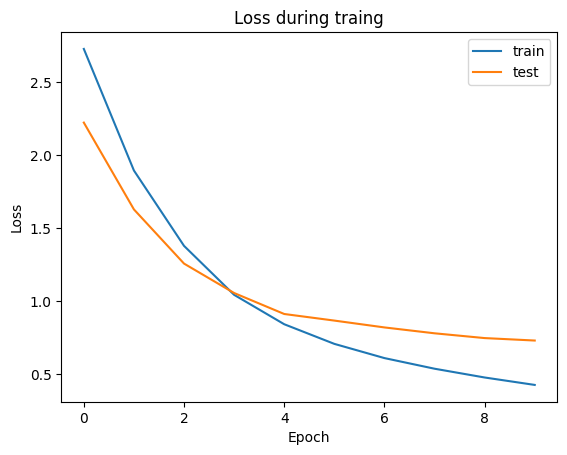

In [55]:
plt.plot(state.loss_train, label='train')
plt.plot(state.loss_test, label='test')
plt.title('Loss during traing')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Test the translation

In [72]:
@torch.no_grad()
def translate(input_sentence, model, length_max = 15, source='en'):
    if source == 'en':
      # prepare input encoder
      input_sentence = ' '.join(input_sentence.strip().split(' ') + ['<eos>']) # add end of sentence
      input_encoder = string2code(input_sentence, word2id_en)
      input_encoder = F.pad(input_encoder, pad=(0,length_max-len(input_encoder)), mode='constant', value=word2id_en['<pad>']).unsqueeze(0).cuda() # create batch

      output = '<bos>'
      output_decode = string2code(output, word2id_fr)
      model.eval()
      while len(output.split(' ')) < length_max:
        output_decode = F.pad(output_decode, pad=(0,length_max-len(output_decode)), mode='constant', value=word2id_fr['<pad>']).unsqueeze(0).cuda() # create batch
        y_pred = model(input_encoder, output_decode)
        # get prediction
        id_pred = torch.argmax(torch.softmax(y_pred[0][len(output.split(' ')) - 1], dim=-1)).item()
        # concatenate to output
        output = output + f' {id2word_fr[id_pred]}'
        if id_pred == word2id_fr['<eos>']:
          break
        output_decode = string2code(output, word2id_fr)
      return output

In [81]:
en_sentence = input()

i love eating chocolate


In [82]:
translate(en_sentence, state.model, length_max = 15, source='en')

'<bos> jadore manger du chocolat <eos>'